In [1]:
import random
import itertools
from deepface import DeepFace
import os
import numpy as np
import pandas as pd 

2024-03-13 22:08:12.921998: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-13 22:08:12.968103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 22:08:12.968146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 22:08:12.969385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 22:08:12.977202: I tensorflow/core/platform/cpu_feature_guar

In [21]:
# Load the DeepFace models
models = [
  "VGG-Face",
  "Facenet512",
  "ArcFace",
  "SFace",
]

backends = [
  'opencv',
  'mtcnn',
  'retinaface',
  'yunet',
]

metrics = ["cosine", "euclidean", "euclidean_l2"]


# Define the path to your testing dataset
test_data_path = '/home/aipark/dataset/different'

In [22]:
# Load the test dataset
test_data = {}
for root, dirs, files in os.walk(test_data_path):
    for file in files:
        person_name = root.split('/')[-1]  # Assuming folder names are the person's names
        if person_name not in test_data:
            test_data[person_name] = []
        test_data[person_name].append(os.path.join(root, file))
        
positives = []
for key, values in test_data.items():
 for i in range(0, len(values)-1):
  for j in range(i+1, len(values)):
   positive = []
   positive.append(values[i])
   positive.append(values[j])
   positives.append(positive)
 
positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

samples_list = list(test_data.values())
 
negatives = []
for i in range(0, len(test_data) - 1):
 for j in range(i+1, len(test_data)):
  cross_product = itertools.product(samples_list[i], samples_list[j])
  cross_product = list(cross_product)
 
  for cross_sample in cross_product:
   negative = []
   negative.append(cross_sample[0])
   negative.append(cross_sample[1])
   negatives.append(negative)
 
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

df = pd.concat([positives, negatives]).reset_index(drop = True)

#df.file_x = "/home/aipark/projects/kh/outputs/df/"+df.file_x
#df.file_y = "/home/aipark/projects/kh/outputs/df/"+df.file_y

In [27]:

# sample df 
df_yes = df[df['decision'] == 'Yes']
df_no = df[df['decision'] == 'No']

# Sample an equal number of rows from each subset
sample_size = min(len(df_yes), len(df_no))
sampled_df = pd.concat([df_yes.sample(n=sample_size, random_state=42), df_no.sample(n=sample_size, random_state=42)])

# Shuffle the sampled DataFrame to randomize the order
sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(sampled_df)

                                           file_x  \
0      /home/aipark/dataset/different/4001/51.png   
1      /home/aipark/dataset/different/4000/12.png   
2      /home/aipark/dataset/different/4003/35.png   
3      /home/aipark/dataset/different/4001/30.png   
4      /home/aipark/dataset/different/4002/24.png   
...                                           ...   
30667  /home/aipark/dataset/different/4000/70.png   
30668  /home/aipark/dataset/different/4002/23.png   
30669  /home/aipark/dataset/different/4001/56.png   
30670  /home/aipark/dataset/different/4000/62.png   
30671  /home/aipark/dataset/different/4000/64.png   

                                           file_y decision  
0       /home/aipark/dataset/different/4002/4.png       No  
1      /home/aipark/dataset/different/4004/19.png       No  
2      /home/aipark/dataset/different/4003/39.png      Yes  
3      /home/aipark/dataset/different/4001/38.png      Yes  
4      /home/aipark/dataset/different/4002/66.png      Yes

In [50]:
model = 'AdaFace'
model = "Facenet512"

backend = 'retinaface'

resp_obj = DeepFace.verify_list(sampled_df['file_x'], sampled_df['file_y'], model_name = model, detector_backend = backend, distance_metric = "cosine", enforce_detection= False)

True positive Mean and Standard deviation: 0.7221 0.1607
False positive Mean and Standard deviation: 0.9215 0.0821
1.0435
                                           file_x  \
28997   /home/aipark/dataset/different/4000/5.png   
48909   /home/aipark/dataset/different/4001/4.png   
58950  /home/aipark/dataset/different/4001/35.png   
63075  /home/aipark/dataset/different/4002/22.png   
28513  /home/aipark/dataset/different/4000/44.png   
...                                           ...   
85612  /home/aipark/dataset/different/4003/45.png   
50143  /home/aipark/dataset/different/4001/55.png   
74154  /home/aipark/dataset/different/4002/30.png   
27451  /home/aipark/dataset/different/4000/30.png   
30474  /home/aipark/dataset/different/4000/69.png   

                                           file_y decision  distance  
28997  /home/aipark/dataset/different/4003/57.png       No    1.0114  
48909  /home/aipark/dataset/different/4003/28.png       No    1.0120  
58950  /home/aipark/dataset/

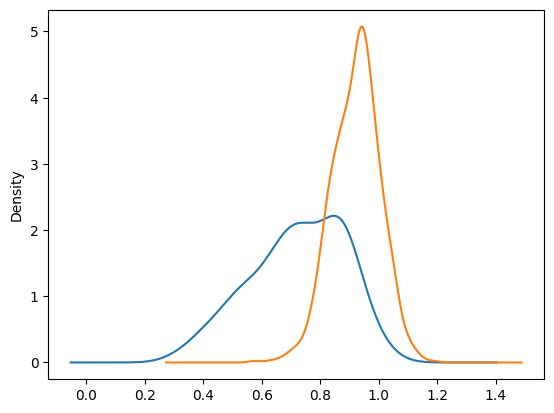

In [49]:
distances = []
for i in range(0, len(instances)):
 distance = round(resp_obj[i]["distance"], 4)
 distances.append(distance)
 
sampled_df["distance"] = distances

tp_mean = round(sampled_df.loc[sampled_df.decision == "Yes", ['distance']].mean().values[0], 4)
tp_std = round(sampled_df.loc[sampled_df.decision == "Yes", ['distance']].std().values[0], 4)
fp_mean = round(sampled_df.loc[sampled_df.decision == "No", ['distance']].mean().values[0], 4)
fp_std = round(sampled_df.loc[sampled_df.decision == "No", ['distance']].std().values[0], 4)

sampled_df[sampled_df.decision == "Yes"].distance.plot.kde()
sampled_df[sampled_df.decision == "No"].distance.plot.kde()

sigma = 2
threshold = round(tp_mean + sigma * tp_std, 4)

print("True positive Mean and Standard deviation:",tp_mean, tp_std)
print("False positive Mean and Standard deviation:",fp_mean, fp_std)
print(threshold)

filtered_df = sampled_df[sampled_df["distance"] > 1]
print(filtered_df)


True positive Mean and Standard deviation: 0.5877 0.1115
False positive Mean and Standard deviation: 0.9092 0.0712
Threshold:  0.8107
Accuracy: 91.0 %

True Positives (TP): 8
False Positives (FP): 90
True Negatives (TN): 902
False Negatives (FN): 0
True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 0.0907258064516129


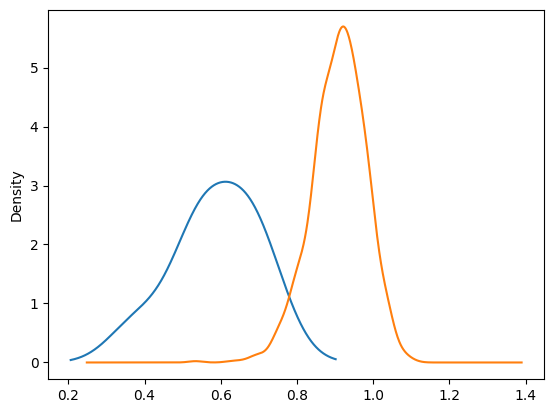

In [2]:
df1 = pd.read_csv('/home/aipark/projects/kh/outputs/digiface/df/AdaFace_opencv.csv')
df2 = pd.read_csv('/home/aipark/projects/kh/outputs/digiface/df/AdaFace_retinaface.csv')
df3 = pd.read_csv('/home/aipark/projects/kh/outputs/digiface/df/Facenet512_fastmtcnn.csv')
df4 = pd.read_csv('/home/aipark/projects/kh/outputs/digiface/df/VGG-Face_mtcnn.csv')


'''weighted_distance = (df1['distance']) 
weighted_df = pd.DataFrame({'distance': weighted_distance, 'decision': df1['decision']})'''

'''weighted_distance = (df2['distance'])
weighted_df = pd.DataFrame({'distance': weighted_distance, 'decision': df2['decision']})'''

'''weighted_distance = (df3['distance'])
weighted_df = pd.DataFrame({'distance': weighted_distance, 'decision': df3['decision']})'''

weighted_distance = (df1['distance'])
weighted_df = pd.DataFrame({'distance': weighted_distance, 'decision': df1['decision']})
'''weighted_distance = (df1['distance'] * 0.25) + (df2['distance'] * 0.15) + (df3['distance'] * 0.4) + (df4['distance'] * 0.2)
weighted_df = pd.DataFrame({'distance': weighted_distance, 'decision': df1['decision']})'''

weighted_df[weighted_df.decision == "Yes"].distance.plot.kde()
weighted_df[weighted_df.decision == "No"].distance.plot.kde()

tp_mean = round(weighted_df.loc[weighted_df.decision == "Yes", ['distance']].mean().values[0], 4)
tp_std = round(weighted_df.loc[weighted_df.decision == "Yes", ['distance']].std().values[0], 4)
fp_mean = round(weighted_df.loc[weighted_df.decision == "No", ['distance']].mean().values[0], 4)
fp_std = round(weighted_df.loc[weighted_df.decision == "No", ['distance']].std().values[0], 4)

sigma = 2
threshold = round(tp_mean + sigma * tp_std, 4)

print("True positive Mean and Standard deviation:",tp_mean, tp_std)
print("False positive Mean and Standard deviation:",fp_mean, fp_std)
print('Threshold: ', threshold)

correct_decisions = ((weighted_df['distance'] < threshold) == (weighted_df['decision'] == 'Yes')) | ((weighted_df['distance'] > threshold) == (weighted_df['decision'] == 'No'))
accuracy = correct_decisions.mean() * 100
print("Accuracy:", accuracy, "%")

print()
# Calculate true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN)
TP = ((weighted_df['distance'] < threshold) & (weighted_df['decision'] == 'Yes')).sum()
FP = ((weighted_df['distance'] < threshold) & (weighted_df['decision'] == 'No')).sum()
TN = ((weighted_df['distance'] >= threshold) & (weighted_df['decision'] == 'No')).sum()
FN = ((weighted_df['distance'] >= threshold) & (weighted_df['decision'] == 'Yes')).sum()

# Calculate true positive rate (TPR) and false positive rate (FPR)
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)

# Print the results
print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)
print("True Positive Rate (TPR):", TPR)
print("False Positive Rate (FPR):", FPR)


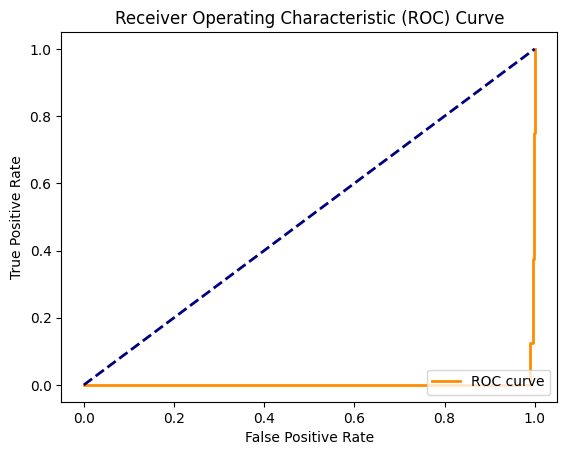

In [3]:
from sklearn.metrics import roc_curve

# Assuming sampled_df contains your DataFrame
# Convert "Yes" and "No" decision to binary labels (1 and 0)
weighted_df['decision_binary'] = (weighted_df['decision'] == 'Yes').astype(int)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(weighted_df['decision_binary'], weighted_df['distance'])

# Plot ROC curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

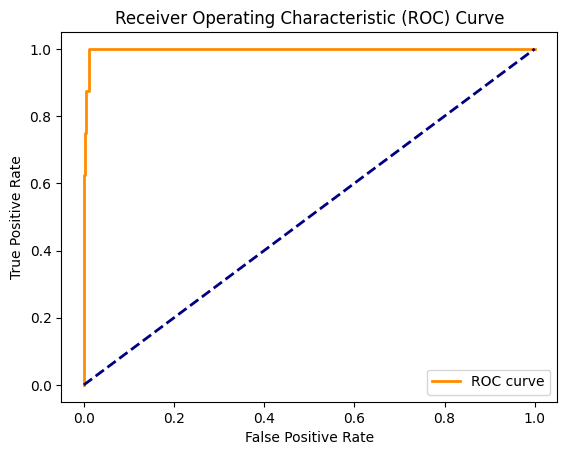

AUROC:  0.9973538306451613


In [6]:
from sklearn.metrics import roc_curve, auc

# 'distance' 값을 반전시켜 새로운 점수 생성
max_distance = weighted_df['distance'].max()
weighted_df['distance_reversed'] = max_distance - weighted_df['distance']

# 반전된 점수를 사용하여 ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(weighted_df['decision_binary'], weighted_df['distance_reversed'])
roc_auc = auc(fpr, tpr)


# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("AUROC: ", roc_auc)